In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize

In [68]:
class GradientFind():
    def __init__(self, f, grad_f=None, treshold=0.1, learning_rate = 0.1, animation_interval_ms=1000) -> None:
        if type(f) == 'function':
            self.function = f
        else:
            self.is_multivariable = False
            if 'y' in f:
                self.is_multivariable = True
                self.x, self.y = sp.symbols('x y')
                formula = sp.sympify(f)
                self.function = sp.lambdify((self.x, self.y), formula)
            else:
                self.x = sp.symbols('x')
                formula = sp.sympify(f)
                self.function = sp.lambdify([self.x], formula)

        if grad_f == None:
            assert type(f) is str, "Variable is not of type string!"
            self.grad_f = self.find_grad(f=f)
        else:
            self.grad_f = grad_f
        self.treshold = treshold
        self.learning_rate = learning_rate
        self.animation_interval_ms = animation_interval_ms

    def find_grad(self, f):
        # Define the variable
        if self.is_multivariable:
            gradient = [sp.diff(sp.sympify(f), var) for var in (self.x, self.y)]
            numgradfun = [sp.lambdify([self.x, self.y], g) for g in gradient]
            return numgradfun
        else:
            gradient = sp.diff(sp.sympify(f), self.x)
            numgradfun = sp.lambdify([self.x], gradient)
            
        return [numgradfun]

    def func_to_minimize(self, vars):
        return self.function(vars[0], vars[1])
    
    def find(self):
       # Параметры градиентного спуска
        if self.is_multivariable:
            x0 = np.array([5, 5])  # Initial values for x and y
            x_values = [x0]
            i = 0

            while True:
                grad = np.array([g(*x0) for g in self.grad_f])
                x_new = x0 - self.learning_rate * grad
                x_values.append(x_new)
                if np.linalg.norm(x_new - x0) < self.treshold:
                    break
                x0 = x_new
                i += 1

            min_finded = x_values[-1]
            print(f'Кол-во шагов = {i}')
            print(f'min -> x = {round(min_finded[0], 5)}, y = {round(min_finded[1], 5)}')
            self.x_values = x_values
            initial_guess = [0, 0]
            result = minimize(self.func_to_minimize, initial_guess)
            y_find = self.function(min_finded[0], min_finded[1])
            #print(y_find)
            #print(result)
            error = abs(result.fun - y_find)
            print(f'Аналитическое решение = {result.x}')
            print(f'Ошибка = {error}')

        else:
            x0 = 5 # Начальное значение
            self.grad_f = self.grad_f[0]

            # Список для хранения значений x на каждой итерации
            x_values = [x0]
            x_param = x_values[-1]

            i = 0

            x_param = x_values[-1] - self.learning_rate * self.grad_f(x_param)
            x_values.append(x_param)
            # Цикл градиентного спуска
            while abs(self.function(x_values[i]) - self.function(x_values[i-1])) > self.treshold:
                x_param = x_values[-1] - self.learning_rate * self.grad_f(x_param)
                x_values.append(x_param)
                i += 1

            min_finded = round(x_values[-1], 5)
            print(f'Кол-во шагов = {i}')
            print(f'min -> x = {min_finded}')
            self.x_values = x_values
            result = minimize(self.function, x0)
            error = abs(result.x - min_finded)
            print(f'Аналитическое решение = {result.x}')
            print(f'Ошибка = {error}')


    def plot_simple(self):
        if self.is_multivariable:
            x_range = np.linspace(-5, 5, 100)
            y_range = np.linspace(-5, 5, 100)
            X, Y = np.meshgrid(x_range, y_range)
            Z = self.function(X, Y)

            plt.figure(figsize=(10, 8))
            plt.contour(X, Y, Z, levels=50)
            plt.scatter([x[0] for x in self.x_values], [x[1] for x in self.x_values], c='red', label='Gradient Descent')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Gradient Descent')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            # Визуализация
            x_range = np.linspace(-5, 5)
            y_values = self.function(x_range)
            plt.figure(figsize=(10, 8))
            plt.plot(x_range, y_values, label='f(x)')
            plt.scatter(self.x_values, self.function(np.array(self.x_values)), c='red', label='Градиентный спуск')

            plt.xlabel('x')
            plt.ylabel('f(x)')
            plt.title('Градиентный спуск')
            plt.legend()
            plt.grid(True)
            
            plt.show()

    def plot_animation(self):
        if self.is_multivariable:
            # Animation for 2D function
            x = np.linspace(-10, 10, 100)
            y = np.linspace(-10, 10, 100)
            X, Y = np.meshgrid(x, y)
            Z = self.function(X, Y)

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

            points, = ax.plot([], [], [], 'ro')  # Points of descent
            arrows = []

            def init():
                points.set_data([], [])
                points.set_3d_properties([])
                return points,

            def update(frame):
                if frame < len(self.x_values) - 1:
                    x_start = self.x_values[frame][0]
                    y_start = self.x_values[frame][1]
                    z_start = self.function(x_start, y_start)

                    x_end = self.x_values[frame + 1][0]
                    y_end = self.x_values[frame + 1][1]
                    z_end = self.function(x_end, y_end)

                    points.set_data([x[0] for x in self.x_values[:frame + 1]], [x[1] for x in self.x_values[:frame + 1]])
                    points.set_3d_properties([self.function(x[0], x[1]) for x in self.x_values[:frame + 1]])

                    # Draw arrow
                    ax.quiver(x_start, y_start, z_start, x_end - x_start, y_end - y_start, z_end - z_start,
                                color='green', arrow_length_ratio=0.1)

                return points,

            ani = FuncAnimation(fig, update, frames=len(self.x_values), init_func=init,
                                blit=True, repeat=False, interval=self.animation_interval_ms)

            # Mark the last point
            ax.scatter(self.x_values[-1][0], self.x_values[-1][1],
                        self.function(self.x_values[-1][0], self.x_values[-1][1]),
                        color='black', s=100, label='Optimum')
            ax.text(self.x_values[-1][0], self.x_values[-1][1], self.function(self.x_values[-1][0], self.x_values[-1][1]),
                    'Optimum', fontsize=10, ha='right', color='black', fontweight='bold')

            plt.title('Gradient Descent Visualization')
            ax.set_xlabel('X axis')
            ax.set_ylabel('Y axis')
            ax.set_zlabel('Z axis (Function value)')
            plt.show()
        else:
            x = np.linspace(-2, 6, 100)
            y = self.function(x)

            fig, ax = plt.subplots()
            ax.plot(x, y, label='Function')
            ax.set_xlim(-2, 6)
            ax.set_ylim(min(y) - 1, max(y) + 1)
            ax.set_title('Градиентный спуск (Визуализация)')
            ax.set_xlabel('x')
            ax.set_ylabel('f(x)')
            ax.legend()

            points, = ax.plot([], [], 'ro')  # Points of descent
            arrows = []

            def init():
                points.set_data([], [])
                return points,

            def update(frame):
                if frame < len(self.x_values) - 1:
                    x_start = self.x_values[frame]
                    x_end = self.x_values[frame + 1]
                    y_start = self.function(x_start)
                    y_end = self.function(x_end)

                    points.set_data(self.x_values[:frame + 1], self.function(np.array(self.x_values[:frame + 1])))
                    
                    # Clear previous arrows
                    # for arrow in arrows:
                    #     arrow.remove()
                    # arrows.clear()

                    # Draw arrow
                    arrow = plt.Arrow(x_start, y_start, x_end - x_start, y_end - y_start, ec='green', width=0.1)
                    ax.add_patch(arrow)
                    arrows.append(arrow)

                return points,

            ani = FuncAnimation(fig, update, frames=len(self.x_values), init_func=init, blit=True, repeat=False, interval=self.animation_interval_ms)


            ax.scatter(self.x_values[-1], self.function(self.x_values[-1]), color='black', s=100, label='Optimum')  # Bold dark point
            ax.text(self.x_values[-1], self.function(self.x_values[-1]), 'Optimum', fontsize=10, ha='right', color='black', fontweight='bold')

            plt.draw()
            plt.show()

Кол-во шагов = 43
min -> x = 0.00027, y = 0.00027
<function _lambdifygenerated at 0x14b635af0>
Аналитическое решение = [0. 0.]
Ошибка = 1.4821387422376482e-07


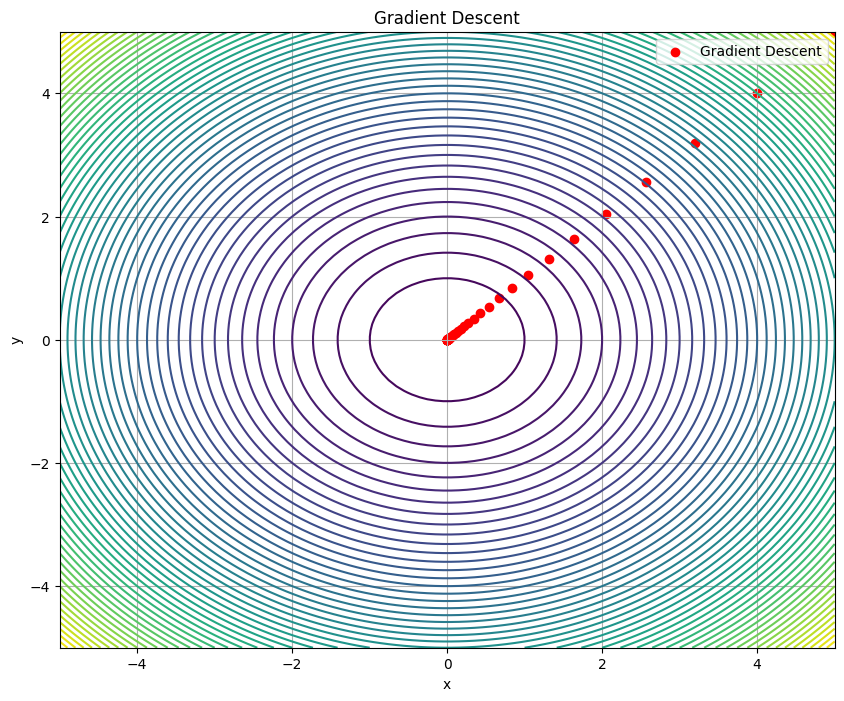

In [71]:
ex = GradientFind(f='x**2+y**2', treshold=0.0001, learning_rate = 0.1)
ex.find()
#ex.plot_animation()
ex.plot_simple()

In [ ]:
# Производная функции
def df(x):
  return 2*x